In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve

import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pandasql import sqldf

In [2]:
df = pd.read_csv('data.csv')

In [3]:
x = df[['country', 'year', 'uniqueid', 'location_type',
       'cellphone_access', 'household_size', 'age_of_respondent',
       'gender_of_respondent', 'relationship_with_head', 'marital_status',
       'education_level', 'job_type']]


y = df[['bank_account']]

x_tr, x_test, y_tr, y_test = train_test_split(x, y,test_size=.25, random_state=12)

In [4]:
x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
x_tr['is_male'] = np.where(x_tr['gender_of_respondent'] == 'Male',1,0)

<ipython-input-4-02e3f9e08314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['is_urban'] = np.where(x_tr['location_type'] == 'Urban',1,0)
<ipython-input-4-02e3f9e08314>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr['cellphone'] = np.where(x_tr['cellphone_access'] == 'Yes',1,0)
<ipython-input-4-02e3f9e08314>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [5]:
x_tr_cont = x_tr[['year','household_size','age_of_respondent','is_urban','cellphone','is_male']]
x_tr_cat = x_tr[['country','relationship_with_head', 'marital_status','education_level', 'job_type']]

In [6]:
# Regroup to reduce number of categories
x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
x_tr_cat.loc[x_tr_cat['education_level'] == 'Other/Dont know/RTA', ['education_level']] = 'No formal education'
x_tr_cat.loc[x_tr_cat['job_type'] == 'Dont Know/Refuse to answer', ['job_type']] = 'No Income'
x_tr_cat.loc[x_tr_cat['relationship_with_head'] == 'Other non-relatives', ['relationship_with_head']] = 'Other relative'

/Users/tawneykirkland/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-6-fd79ac22a8b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_tr_cat.loc[x_tr_cat['marital_status'] == 'Dont know', ['marital_status']] = 'Single/Never Married'
<ipython-input-6-fd79ac22a8b3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-cop

In [7]:
# Create dummy variable for bank account
y_tr['bank_acc'] = np.where(y_tr['bank_account'] == 'Yes', 1,0)

<ipython-input-7-b1430f2c33c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_tr['bank_acc'] = np.where(y_tr['bank_account'] == 'Yes', 1,0)


In [12]:
df_train = pd.concat([x_tr,y_tr],axis=1)
df_train

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,is_urban,cellphone,is_male,bank_account,bank_acc
13455,Rwanda,2016,uniqueid_7388,Rural,No,3,76,Female,Head of Household,Widowed,No formal education,Farming and Fishing,0,0,0,No,0
9193,Rwanda,2016,uniqueid_3126,Rural,Yes,4,26,Female,Spouse,Married/Living together,Primary education,Farming and Fishing,0,1,0,No,0
14346,Rwanda,2016,uniqueid_8279,Rural,No,5,47,Male,Head of Household,Married/Living together,No formal education,Farming and Fishing,0,0,1,No,0
14702,Rwanda,2016,uniqueid_8647,Rural,No,2,50,Female,Head of Household,Widowed,Primary education,Farming and Fishing,0,0,0,No,0
13465,Rwanda,2016,uniqueid_7398,Urban,Yes,3,49,Female,Head of Household,Widowed,Primary education,Remittance Dependent,1,1,0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3714,Kenya,2018,uniqueid_3715,Rural,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent,0,0,1,No,0
7409,Rwanda,2016,uniqueid_1342,Rural,No,4,54,Female,Head of Household,Married/Living together,No formal education,Remittance Dependent,0,0,0,No,0
19709,Tanzania,2017,uniqueid_4907,Rural,Yes,6,21,Female,Parent,Divorced/Seperated,Primary education,Informally employed,0,1,0,No,0
5787,Kenya,2018,uniqueid_5788,Rural,Yes,5,34,Male,Head of Household,Married/Living together,Primary education,Informally employed,0,1,1,No,0


## EDA for target variable: Has bank account (yes/no)
Analysis of train sample (including val)

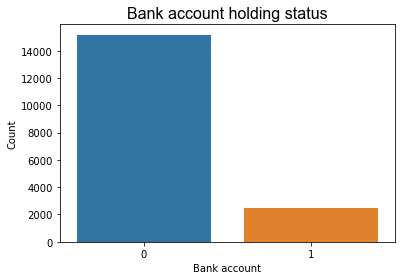

In [18]:
sns.countplot(x='bank_acc', data=df_train)
plt.title('Bank account holding status',family='arial',fontsize=16)
plt.xlabel('Bank account')
plt.ylabel('Count')
plt.show;

In [17]:
count_no_acc = len(df_train[df_train['bank_acc']==0])
count_acc = len(df_train[df_train['bank_acc']==1])
pct_of_no_acc = count_no_acc/(count_no_acc+count_acc)
print("percentage of no account:", pct_of_no_acc*100)
pct_of_acc = count_acc/(count_no_acc+count_acc)
print("percentage of account", pct_of_acc*100)

percentage of no account: 85.95476959700731
percentage of account 14.04523040299269


Classes are very __imbalanced__. How to deal with this?

Text(0, 0.5, 'Count')

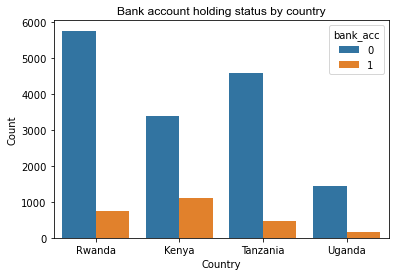

In [33]:
bank_country = sns.countplot(
        data=df_train,
        x="country", hue="bank_acc")
plt.title('Bank account holding status by country',family='arial',fontsize=12)
plt.xlabel('Country')
plt.ylabel('Count')

In [47]:
rwanda_acc = df_train[(df_train['country']=='Rwanda') & (df_train['bank_acc']== 1)].count()
rwanda_no_acc = df_train[(df_train['country']=='Rwanda') & (df_train['bank_acc']== 0)].count()
pct_rwanda_no_acc = rwanda_no_acc / (rwanda_acc + rwanda_no_acc)
print("Rwanda percentage of no account:", pct_rwanda_no_acc*100)
pct_rwanda_acc = 1-pct_rwanda_no_acc
print("Rwanda percentage of account", pct_rwanda_acc*100)

Rwanda percentage of no account: country                   88.646489
year                      88.646489
uniqueid                  88.646489
location_type             88.646489
cellphone_access          88.646489
household_size            88.646489
age_of_respondent         88.646489
gender_of_respondent      88.646489
relationship_with_head    88.646489
marital_status            88.646489
education_level           88.646489
job_type                  88.646489
is_urban                  88.646489
cellphone                 88.646489
is_male                   88.646489
bank_account              88.646489
bank_acc                  88.646489
dtype: float64
Rwanda percentage of account country                   11.353511
year                      11.353511
uniqueid                  11.353511
location_type             11.353511
cellphone_access          11.353511
household_size            11.353511
age_of_respondent         11.353511
gender_of_respondent      11.353511
relationship_with_head 

Text(0, 0.5, 'Count')

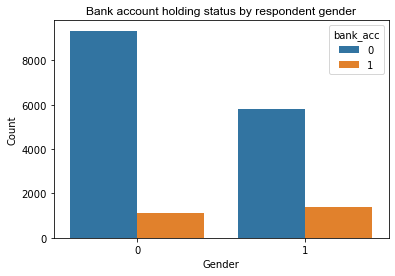

In [34]:
bank_gender = sns.countplot(
        data=df_train,
        x="is_male", hue="bank_acc")
plt.title('Bank account holding status by respondent gender',family='arial',fontsize=12)
plt.xlabel('Gender')
plt.ylabel('Count')

Majority of respondents in the sample identified as female; lower percentage of females have an account in comparison to male respondents

Text(0, 0.5, 'Count')

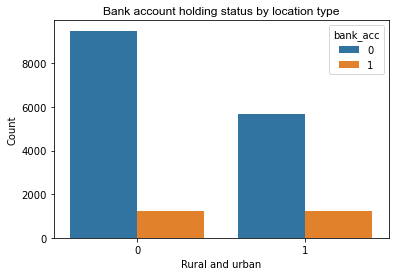

In [35]:
bank_urban = sns.countplot(
        data=df_train,
        x="is_urban", hue="bank_acc")
plt.title('Bank account holding status by location type',family='arial',fontsize=12)
plt.xlabel('Rural and urban')
plt.ylabel('Count')